# ERA5 Mean Turbulent Surface Stress

- Data 2020 - downloaded resampled to daily resolution with 1-hourly (res for resampling) [Data Link](https://cds.climate.copernicus.eu/apps/user-apps/app-c3s-daily-era5-statistics?dataset=reanalysis-era5-single-levels&product_type=reanalysis&variable_e5sl=eastward_turbulent_surface_stress&pressure_level_e5sl=-&statistic=daily_mean&year_e5sl=2020&month=01&frequency=1-hourly&time_zone=UTC%2B00:00&grid_e5=0.25/0.25&area.lat:record:list:float=36&area.lat:record:list:float=45&area.lon:record:list:float=-20&area.lon:record:list:float=-5)
- Units: $\frac{N}{m^2}$
- Compare to the surface stress calculated from the 10m wind components (2020) 

In [1]:
## import packages
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from global_land_mask import globe
import glob
import os
import my_functions

## Load all Data

### Calculate weekly mean (and save)

In [3]:
os.chdir("/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/Surface_stress/")

# load 19th and 20th century data separatly ... to avoid server crashing (and drop empty coordinate "realization"
#TSM_19th = xr.merge([xr.open_dataset(f) for f in glob.glob('Turbulent_mean/*_19*.nc')])
#TSM_19th = TSM_19th.drop_vars(["realization"])
#TSM_20th = xr.merge([xr.open_dataset(f) for f in glob.glob('Turbulent_mean/*_20*.nc')])
#TSM_20th = TSM_20th.drop_vars(["realization"])

# merge datasets
#TSM_all = xr.merge([TSM_19th, TSM_20th])

# save as netcdf 
#TSM_all.to_netcdf("Turbulent_mean/Turbulent_mean_all.nc")

In [14]:
# load data
TSM_all = xr.open_dataset('Turbulent_mean/Turbulent_mean_all.nc')

In [15]:
TSM_all

<xarray.Dataset> Size: 308MB
Dimensions:  (time: 15402, lat: 41, lon: 61)
Coordinates:
  * time     (time) datetime64[ns] 123kB 1981-12-01 1981-12-02 ... 2024-01-31
  * lat      (lat) float64 328B 35.0 35.25 35.5 35.75 ... 44.25 44.5 44.75 45.0
  * lon      (lon) float64 488B -20.0 -19.75 -19.5 -19.25 ... -5.5 -5.25 -5.0
Data variables:
    metss    (time, lat, lon) float32 154MB ...
    mntss    (time, lat, lon) float32 154MB ...
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-04-16T05:35 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

In [6]:
## resample ERA5 data to same weekly resolution as SST upwelling index (Weekly mean Sat-Fr & time stamp Tue)

# time = 'W-SAT' -> resamples to weekly time res. starting on a Saturday (default is Sunday)
# closed = 'left' -> means [start date, end_date) i.e. start date is included and end_date is exluded in the interval I choose 
# label = 'left' -> the time stamp from the start of the interval is assigned
TSM_weekly_mean = TSM_all.resample(time = 'W-SAT', closed = 'left', label = 'left').mean() 
TSM_weekly_std =  TSM_all.resample(time = 'W-SAT', closed = 'left', label = 'left').std() 

# change time label ->I want to add 3 days to my time coordinate to move my time stamp from Sat to Tue to match SST upwelling index format
TSM_weekly_mean['time'] = TSM_weekly_mean.time + np.timedelta64(3, 'D')
TSM_weekly_std['time'] = TSM_weekly_std.time + np.timedelta64(3, 'D')

In [18]:
# save as netcdf 
TSM_weekly_mean.to_netcdf("Turbulent_mean/Turbulent_mean_weekly.nc")
TSM_weekly_std.to_netcdf("Turbulent_mean/Turbulent_std_weekly.nc")

In [16]:
## add land mask (do not need to save this I will use ERA5 land sea mask from ERA5_land_sea_mask.nc)
TSM_weekly_mean = my_functions.land_mask_add(TSM_weekly_mean)
TSM_wekkly_std = my_functions.land_mask_add(TSM_weekly_std)

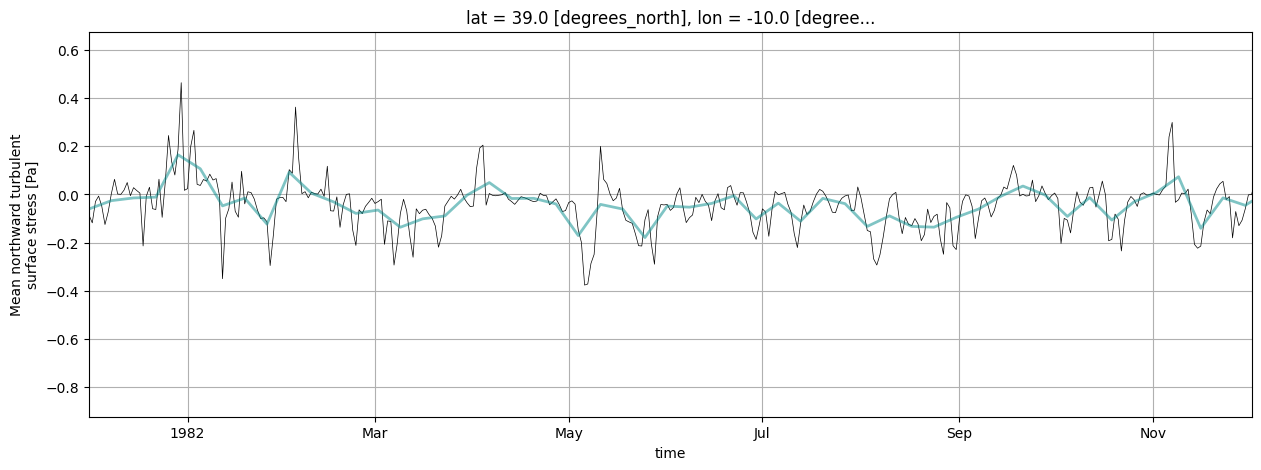

In [7]:
fig = plt.figure(figsize = (15,5))
TSM_all.mntss.sel(lon = -10, lat = 39).plot(color = 'k', linewidth = 0.5, xlim = (TSM_all.time[0], TSM_all.time[366]))
TSM_weekly_mean.mntss.sel(lon = -10, lat = 39).plot(color = 'darkcyan', linewidth = 2, alpha = 0.5)
plt.grid()

## Example 2020

In [8]:
## subset data
TSM_weekly_mean_20 = TSM_weekly_mean.sel(time = slice ("2020-01-01", "2020-12-31"))
TSM_weekly_std_20 = TSM_weekly_std.sel(time = slice ("2020-01-01", "2020-12-31"))

In [9]:
## upwelling index
TSM_weekly_mean_20 = my_functions.upwelling_index(TSM_weekly_mean_20, TSM_weekly_mean_20.lat,  TSM_weekly_mean_20.lon, TSM_weekly_mean_20.metss, TSM_weekly_mean_20.mntss)

In [10]:
TSM_weekly_mean_20

<xarray.Dataset> Size: 5MB
Dimensions:          (lat: 41, lon: 61, time: 52)
Coordinates:
  * lat              (lat) float64 328B 35.0 35.25 35.5 ... 44.5 44.75 45.0
  * lon              (lon) float64 488B -20.0 -19.75 -19.5 ... -5.5 -5.25 -5.0
  * time             (time) datetime64[ns] 416B 2020-01-07 ... 2020-12-29
Data variables:
    metss            (time, lat, lon) float32 520kB -0.01367 -0.01414 ... 0.332
    mntss            (time, lat, lon) float32 520kB -0.001923 ... -0.1094
    land_mask        (lat, lon) bool 3kB False False False ... False False False
    ek_trans_u       (time, lat, lon) float64 1MB -0.02242 -0.04073 ... -1.035
    ek_trans_v       (time, lat, lon) float64 1MB -0.1594 -0.1649 ... 3.141
    wind_stress      (time, lat, lon) float32 520kB 0.0138 0.01456 ... 0.3496
    upwelling_index  (time, lat, lon) float64 1MB 0.02242 0.04073 ... 1.035
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-04-16T05:35 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

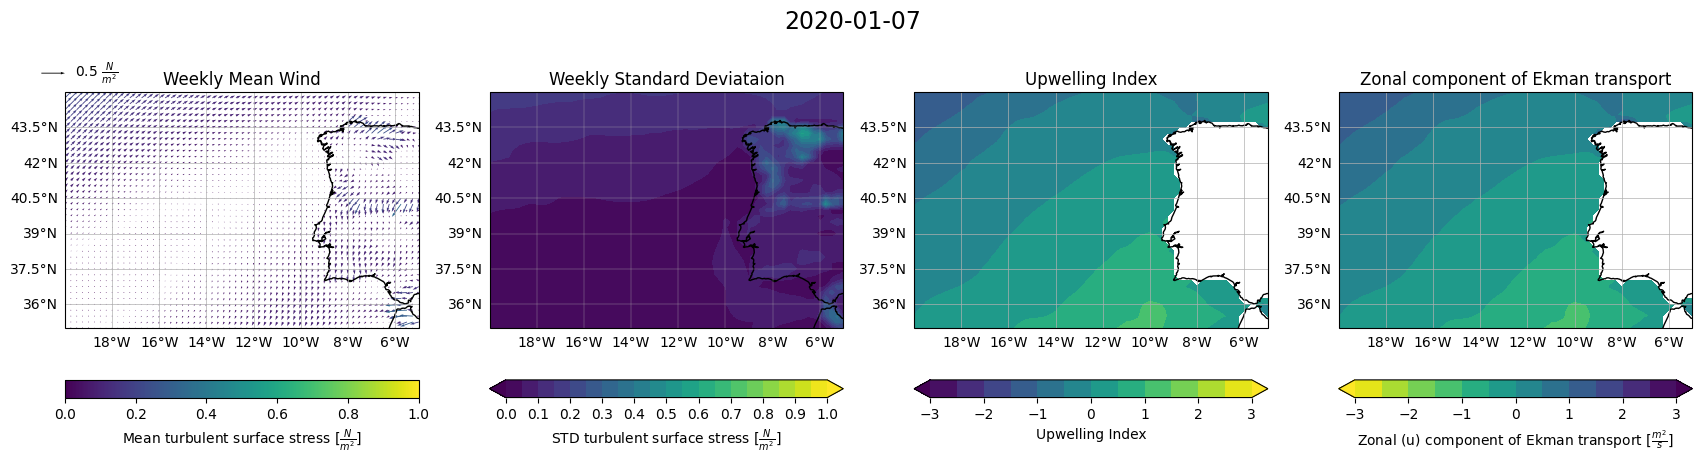

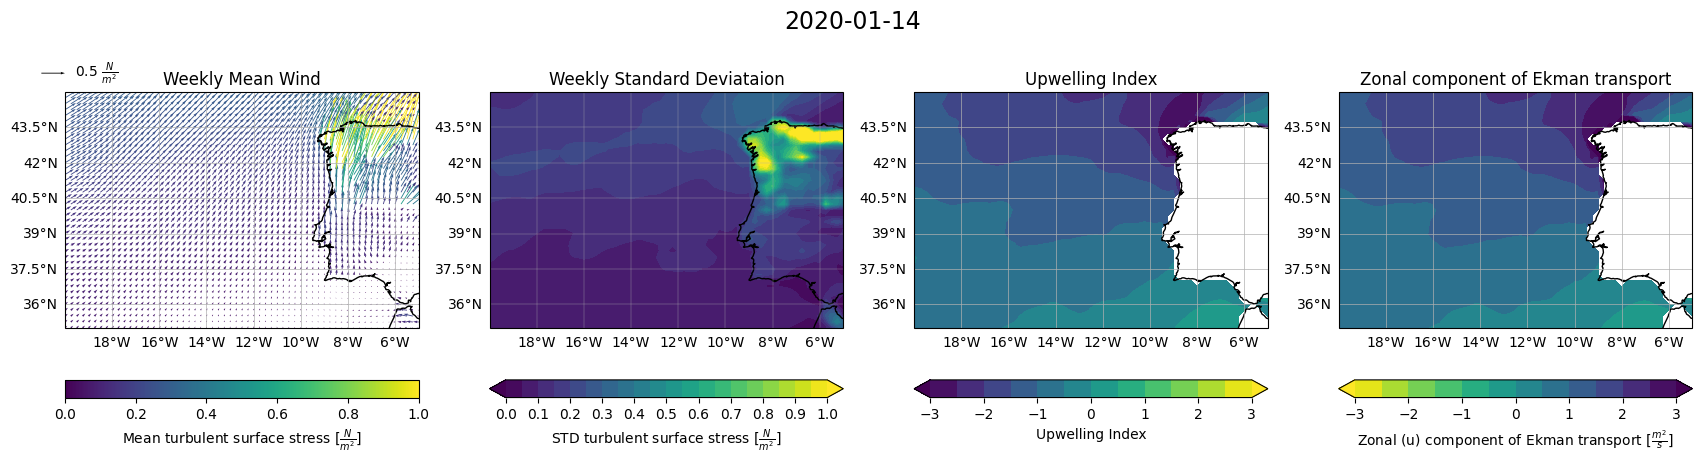

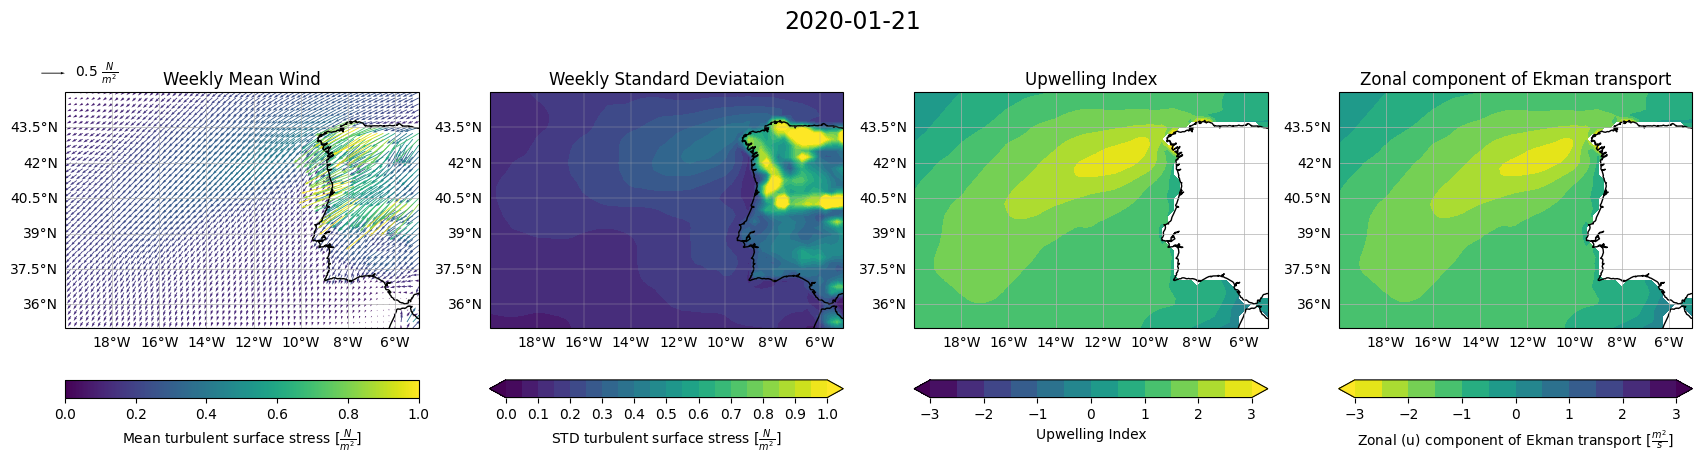

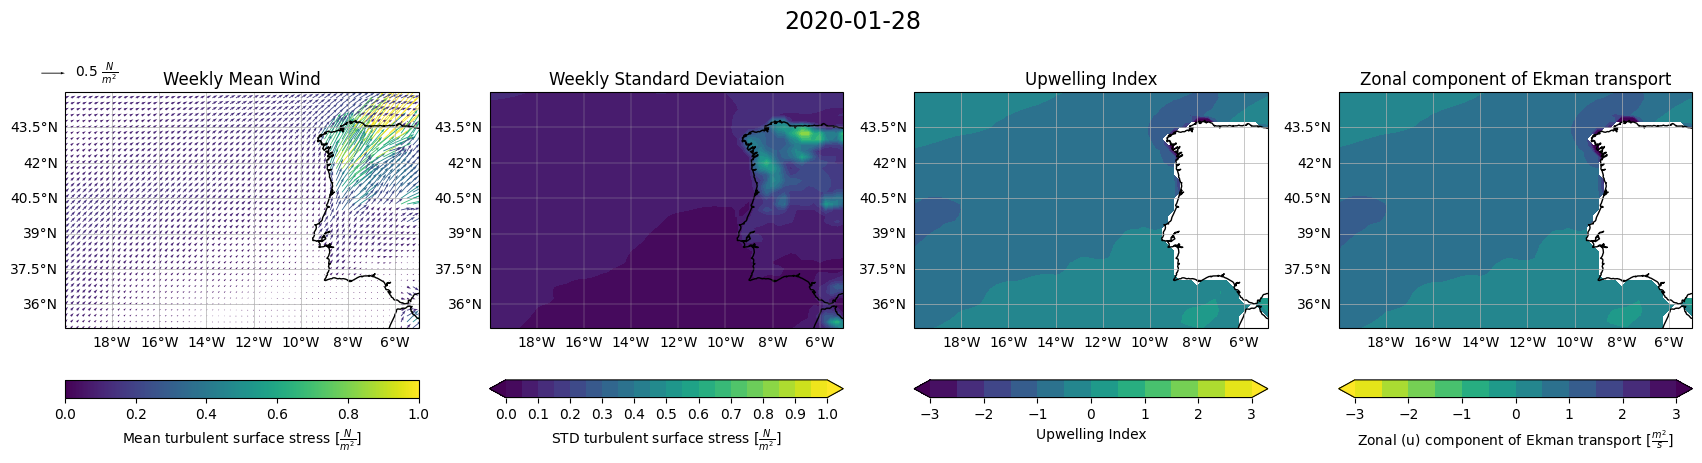

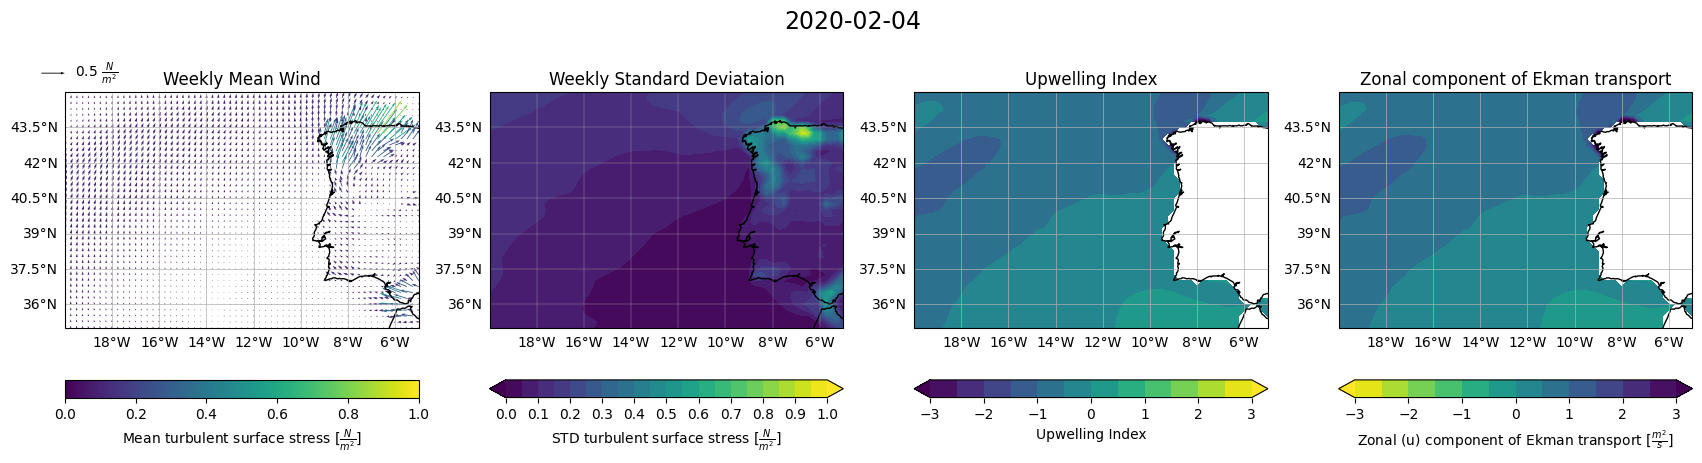

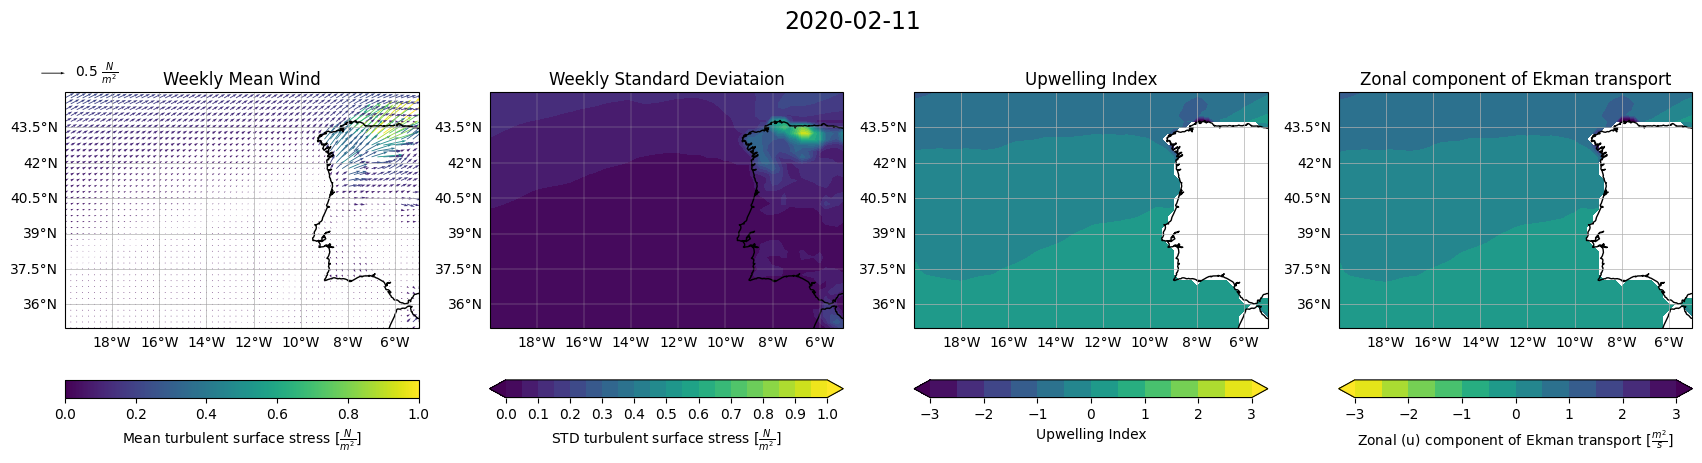

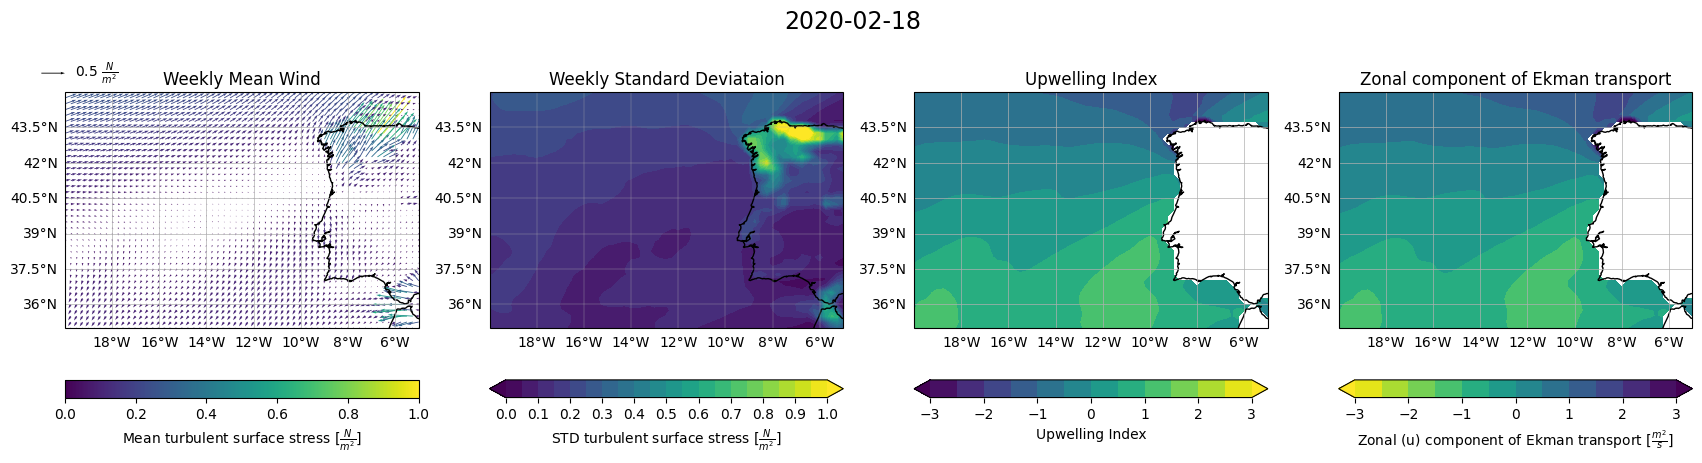

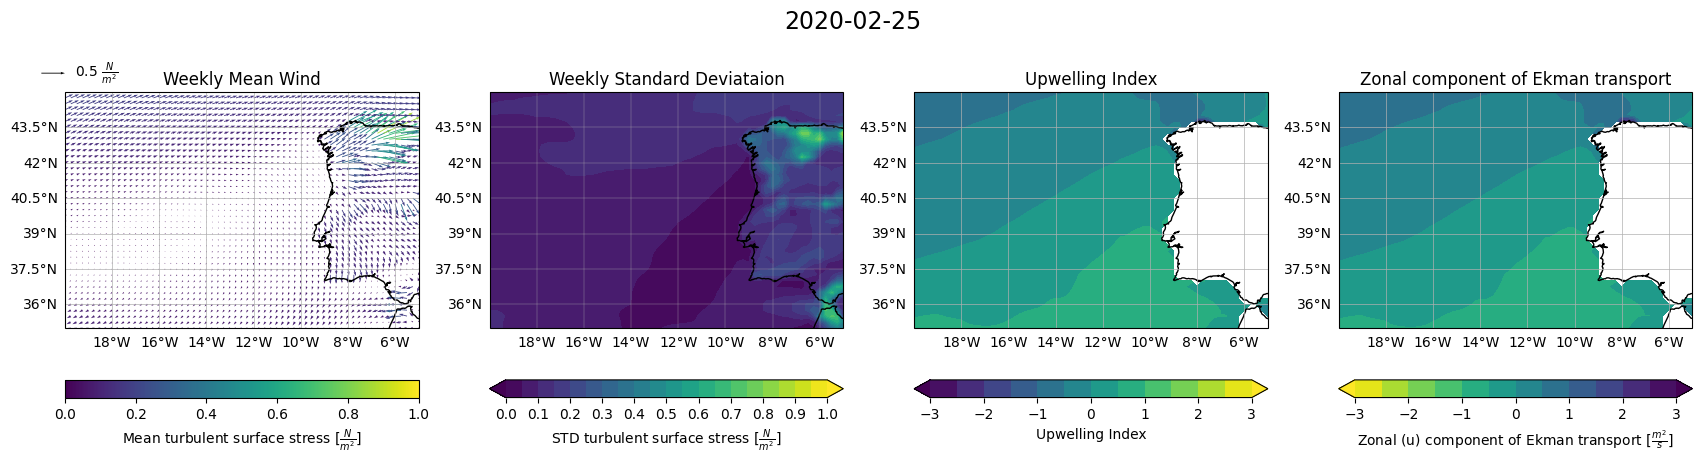

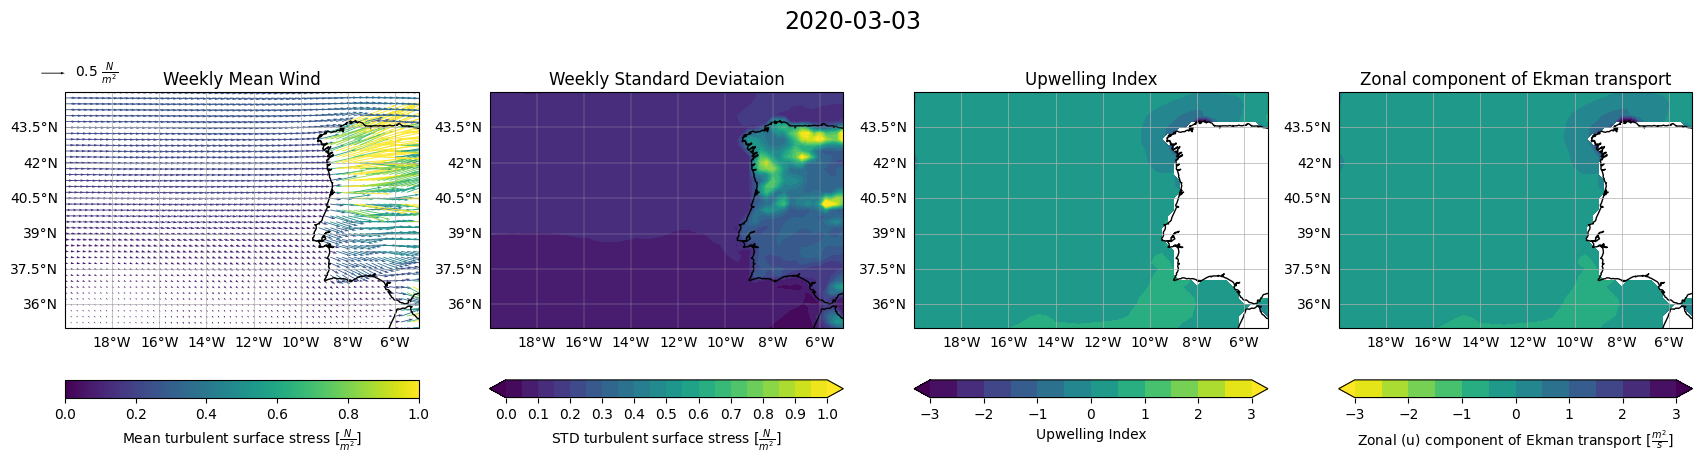

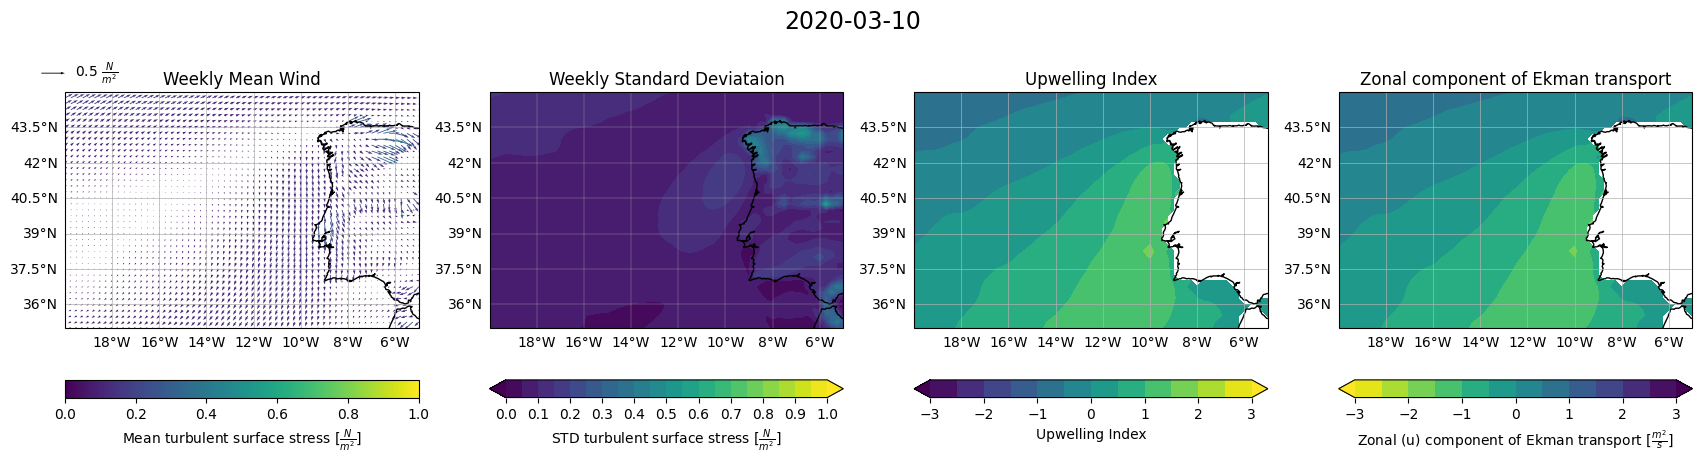

In [11]:
### plot 
for i in np.arange(0, 10, 1): #len(TSM_weekly_mean_20.time.values), 1):
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize = (21, 4.5), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # set up cartopy
    ax1.set_extent([-20, -5, 45, 35])
    ax1.coastlines()
    gls = ax1.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
    # plot data
    col = np.hypot(TSM_weekly_mean_20.metss.isel(time = i), TSM_weekly_mean_20.mntss.isel(time = i))
    im1 = ax1.quiver(TSM_weekly_mean_20.lon, TSM_weekly_mean_20.lat, TSM_weekly_mean_20.metss.isel(time = i), TSM_weekly_mean_20.mntss.isel(time = i), 
                     col, clim = [0,1], 
                     angles='xy', scale_units='xy', scale = 0.5)
    ax1.set_title('Weekly Mean Wind')
    plt.colorbar(im1, orientation = 'horizontal', label = r'Mean turbulent surface stress [$\frac{N}{m^2}$]', fraction = 0.06)
    qk1 = ax1.quiverkey(im1, 0, 1.08, 0.5, r'0.5 $\frac{N}{m^2}$', labelpos='E')
    
    # set up cartopy
    ax2.set_extent([-20, -5, 45, 35])
    ax2.coastlines()
    gls = ax2.gridlines(draw_labels=True, linewidth = 0.25)
    gls.top_labels = False 
    gls.right_labels = False
    # plot std as function the length of the hypothenuse -> combine the vectors
    dat = np.hypot(TSM_weekly_std_20.metss.isel(time = i), TSM_weekly_std_20.mntss.isel(time = i))
    im2 = ax2.contourf(TSM_weekly_std_20.lon, TSM_weekly_std_20.lat, dat, transform = ccrs.PlateCarree(), levels = np.arange(0, 1.05, 0.05), extend = 'both')
    ax2.set_title('Weekly Standard Deviataion')
    #ax2.quiver(TSM_weekly_std_20.lon, TSM_weekly_std_20.lat, TSM_weekly_std_20.metss.isel(time = i), TSM_weekly_std_20.mntss.isel(time = i)) # if I wanted to preserver information on direction I'd have to plot this
    plt.colorbar(im2, orientation = 'horizontal', label = r'STD turbulent surface stress [$\frac{N}{m^2}$]', fraction = 0.06, ticks = np.arange(0, 1.1, 0.1))

    # set up cartopy
    ax3.set_extent([-20, -5, 45, 35])
    ax3.coastlines()
    gls = ax3.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
    # plot data
    im3 = ax3.contourf(TSM_weekly_mean_20.lon, TSM_weekly_mean_20.lat, TSM_weekly_mean_20.upwelling_index.isel(time = i).where(TSM_weekly_mean_20.land_mask == False), 
                       transform = ccrs.PlateCarree(), levels = np.arange(-3, 3.5, 0.5), extend = 'both')
    ax3.set_title('Upwelling Index')
    plt.colorbar(im3, orientation = 'horizontal', label = r'Upwelling Index', fraction = 0.06, ticks = np.arange(-3, 4, 1))

    # set up cartopy
    ax4.set_extent([-20, -5, 45, 35])
    ax4.coastlines()
    gls = ax4.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
    # plot data
    im4 = ax4.contourf(TSM_weekly_mean_20.lon, TSM_weekly_mean_20.lat, TSM_weekly_mean_20.ek_trans_u.isel(time = i).where(TSM_weekly_mean_20.land_mask == False), 
                       transform = ccrs.PlateCarree(), levels = np.arange(-3, 3.5, 0.5), extend = 'both', cmap = 'viridis_r')
    ax4.set_title('Zonal component of Ekman transport')
    plt.colorbar(im4, orientation = 'horizontal', label = r'Zonal (u) component of Ekman transport [$\frac{m^2}{s}$]', fraction = 0.06, ticks = np.arange(-3, 4, 1))
    
    fig.suptitle(f'{str(TSM_weekly_mean_20.time[i].values)[0:10]}', fontsize = 17);
    #fig.tight_layout()


## Compare mean wind stress to wind stress derived from wind speed at 10m
use 2020 as an example

In [12]:
## load wind speed data for 2020
Wind10_20 = xr.merge([xr.open_dataset(f) for f in glob.glob("Wind_10m/*.nc")])
Wind10_20 = Wind10_20.drop_vars(["realization"])

In [13]:
## resample to weekly res
Wind10_20_weekly_mean = Wind10_20.resample(time = 'W-SAT', closed = 'left', label = 'left').mean() 
Wind10_20_weekly_mean['time'] = Wind10_20_weekly_mean.time + np.timedelta64(3, 'D')

In [14]:
Wind10_20

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 366, lat: 41, lon: 61)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
  * lat      (lat) float64 328B 35.0 35.25 35.5 35.75 ... 44.25 44.5 44.75 45.0
  * lon      (lon) float64 488B -20.0 -19.75 -19.5 -19.25 ... -5.5 -5.25 -5.0
Data variables:
    v10      (time, lat, lon) float32 4MB 6.152 6.012 5.889 ... -6.359 -6.257
    u10      (time, lat, lon) float32 4MB -1.473 -1.697 -1.955 ... 4.783 4.908
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-04-23T15:12 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

In [15]:
## calculate the wind stress on the ocean surface from the wind speed at 10m
# from Lecture 7 & Bakun
# variables 
rho_air = 1.2 # density of air [kg/m^3] 
C_D = 1.45e-3 # drag coefficient [dimensionless] # could be calculated as function of wind speed Ferreira et al. 2022
u = Wind10_20_weekly_mean.u10 # wind speed in u direction [m/s]
v = Wind10_20_weekly_mean.v10 # wind speed in v direction [m/s]

Wind10_20_weekly_mean['v_stress'] = rho_air * C_D * np.sqrt(u**2 + v**2) * v
Wind10_20_weekly_mean['u_stress'] = rho_air * C_D * np.sqrt(u**2 + v**2) * u

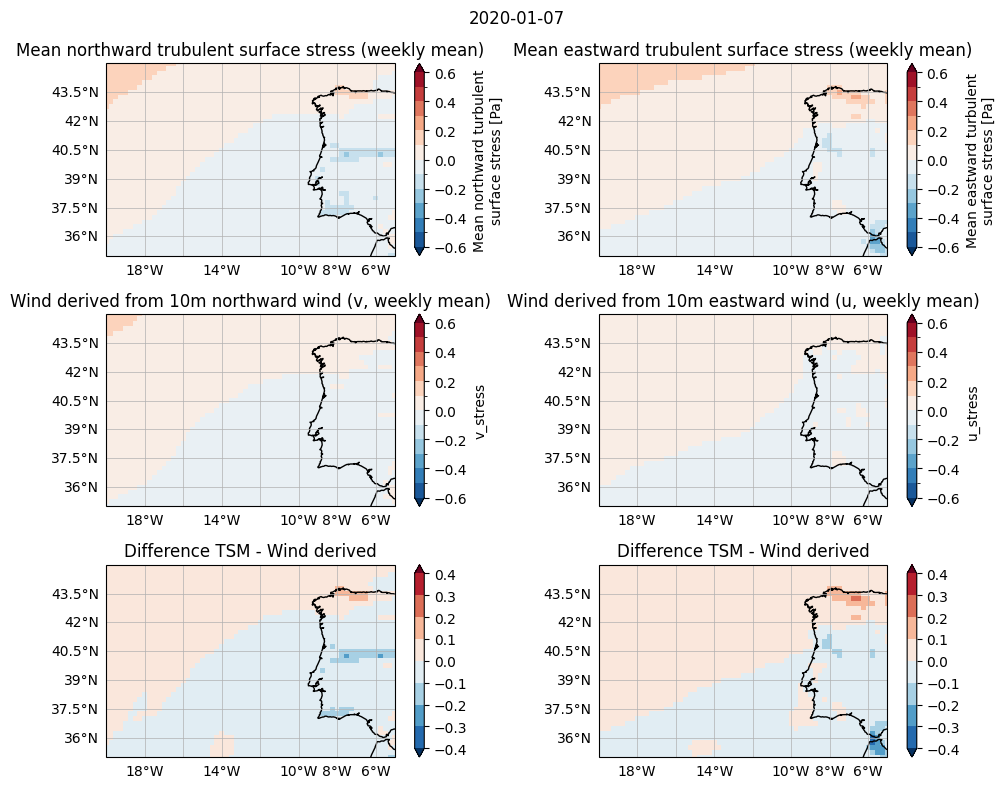

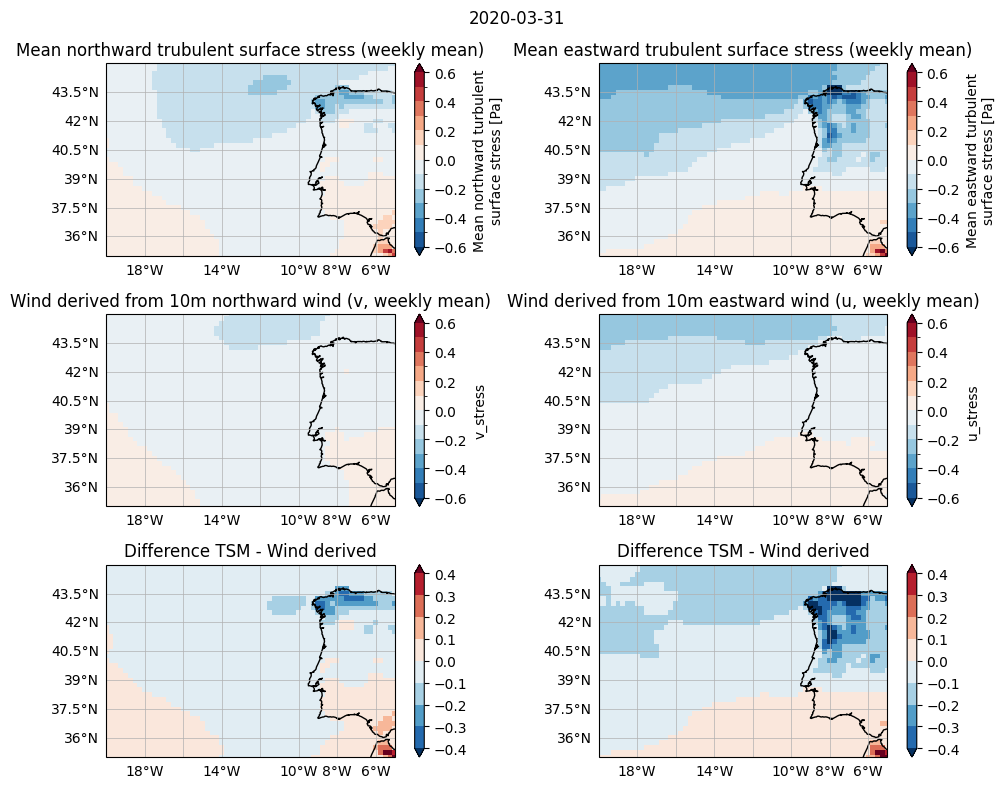

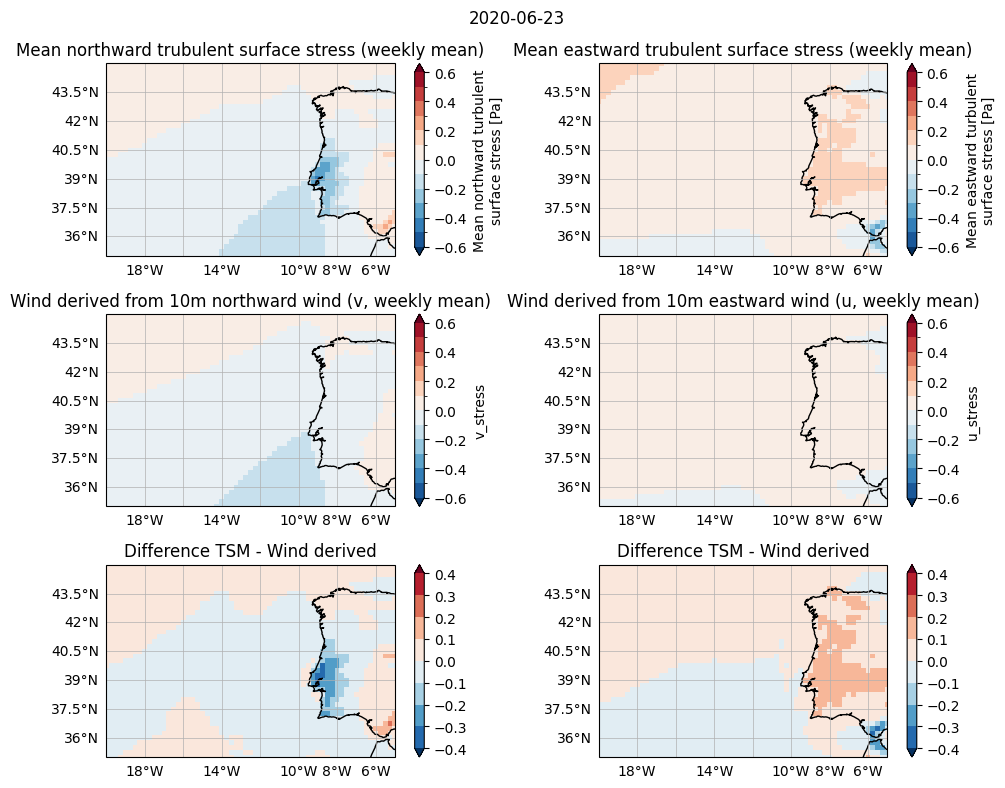

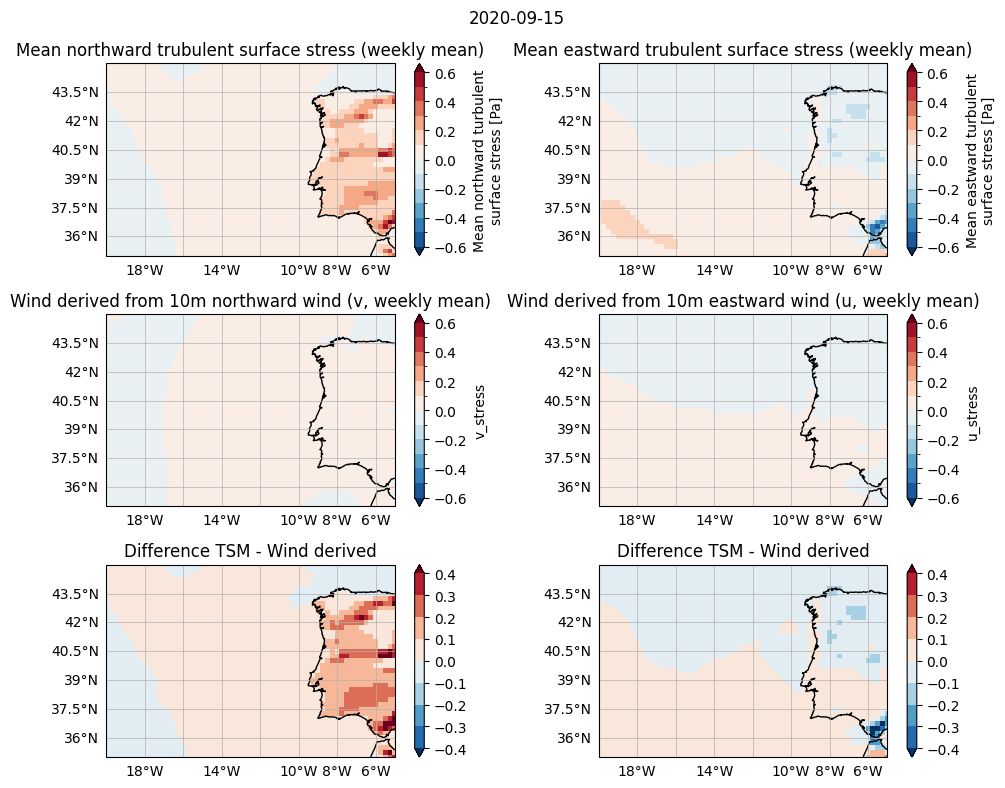

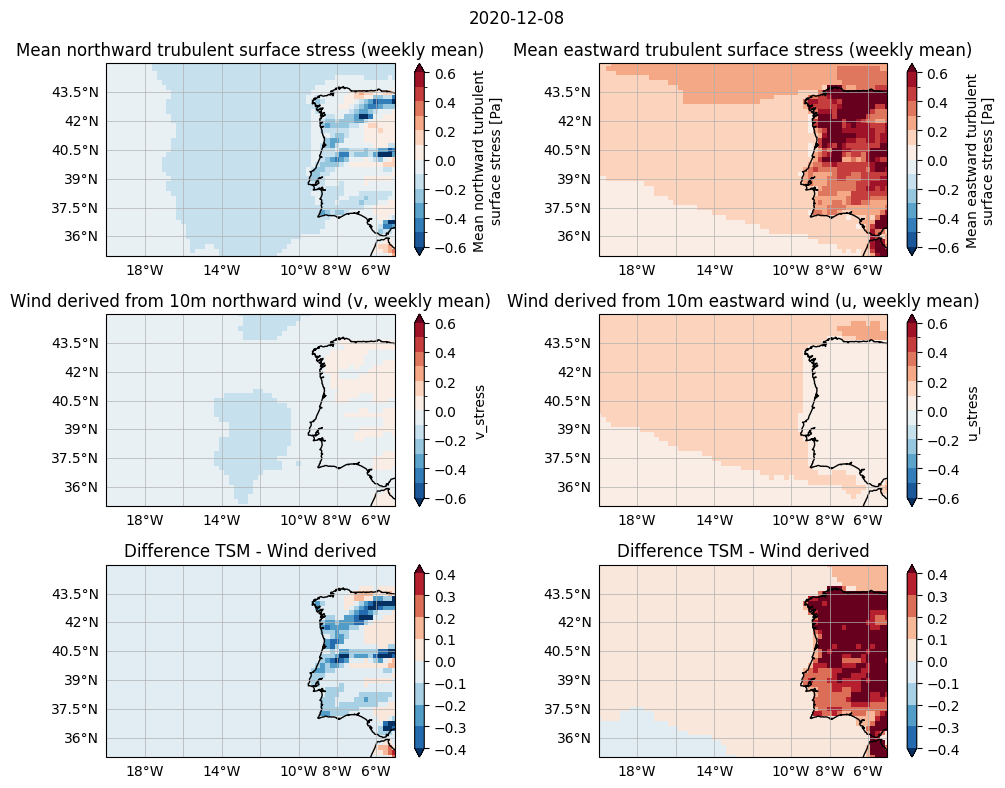

In [20]:
for i in np.arange(0, 53, 12):
    fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2, figsize = (10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_extent([-20, -5, 45, 35])
        ax.coastlines()
        gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
        gls.top_labels = False 
        gls.right_labels = False
        
    TSM_weekly_mean_20.mntss.isel(time = i).plot(ax = ax1, cmap = 'RdBu_r', levels = np.arange(-0.6, 0.7, 0.1), extend = 'both')
    ax1.set_title('Mean northward trubulent surface stress (weekly mean)')
    TSM_weekly_mean_20.metss.isel(time = i).plot(ax = ax2, cmap = 'RdBu_r', levels = np.arange(-0.6, 0.7, 0.1), extend = 'both')
    ax2.set_title('Mean eastward trubulent surface stress (weekly mean)')
    Wind10_20_weekly_mean.v_stress.isel(time = i+1).plot(ax = ax3, cmap = 'RdBu_r', levels = np.arange(-0.6, 0.7, 0.1), extend = 'both') # goes back a week if I don't + 1 
    ax3.set_title('Wind derived from 10m northward wind (v, weekly mean)')
    Wind10_20_weekly_mean.u_stress.isel(time = i+1).plot(ax = ax4, cmap = 'RdBu_r', levels = np.arange(-0.6, 0.7, 0.1), extend = 'both') # goes back a week if I don't + 1 
    ax4.set_title('Wind derived from 10m eastward wind (u, weekly mean)')
    
    diff_meridional =  TSM_weekly_mean_20.mntss.isel(time = i) - Wind10_20_weekly_mean.v_stress.isel(time = i+1)
    diff_zonal = TSM_weekly_mean_20.metss.isel(time = i) - Wind10_20_weekly_mean.u_stress.isel(time = i+1) 

    diff_meridional.plot(ax = ax5, cmap = 'RdBu_r', levels = np.arange(-0.4, 0.5, 0.1), extend = 'both')
    ax5.set_title('Difference TSM - Wind derived')
    diff_zonal.plot(ax = ax6, cmap = 'RdBu_r', levels = np.arange(-0.4, 0.5, 0.1), extend = 'both')
    ax6.set_title('Difference TSM - Wind derived')

    fig.suptitle(f'{str(Wind10_20_weekly_mean.time.isel(time = i+1).values)[0:10]}')
    fig.tight_layout()